# 9.2 Optimising with NumPy

*Estimated time for this notebook: 30 minutes*

TODO: 
- [ ] something on numpy
- [ ] docstrings
- [ ] add asserts
- [ ] Why is numpy faster

- Numpy ndarrays: more efficient in "doing" something to every element in an array than looping over elements

## Operations on `ndarray`

If we have our values in a `ndarry`, we apply operations to each element in the array in one go, without having to loop over it. 

First, we want a `numpy ndarray` containing the complex values that we previously used as input to our function.

In [1]:
xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]
# list with complex values
cs_listcomp = [[(x + y*1j) for x in xs] for y in ys]

In [2]:
import numpy as np

In [3]:
cs = np.asarray(cs_listcomp)

In [4]:
cs.shape

(300, 300)

We now want to compare adding a constant to every element of the array by 
1) using a for loop
2) using numpy operators.

In [5]:
# we need to make copies of array to avoid overwriting it
cs_loop = cs.copy()
cs_numpy = cs.copy()

In [6]:
%%timeit 
for i in range(cs_loop.shape[0]):
    for j in range(cs_loop.shape[1]):
        cs_loop[i][j] = cs_loop[i][j] + 10

82 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Sometimes, you can use operators such as `+` as if we were dealing with single values. This is because the Numpy ndarrays have overridden the add operation.

In [7]:
%%timeit
cs_numpy + 10

105 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


But most Python functions do not know how to handle multi-dimensional arrays so we'll use Numpy implementations where they exist.

In [ ]:
import math

math.sqrt(cs)

In [8]:
np.sqrt(cs)

array([[0.38908588-1.28506335j, 0.38980707-1.28268581j,
        0.39053184-1.28030535j, ..., 0.89141291-0.56090729j,
        0.89409221-0.55922644j, 0.8967725 -0.55755501j],
       [0.38670802-1.2843454j , 0.38742629-1.2819643j ,
        0.38814812-1.27958025j, ..., 0.88972681-0.55822378j,
        0.89241558-0.55654191j, 0.89510532-0.55486953j],
       [0.38432663-1.28363038j, 0.38504193-1.28124573j,
        0.3857608 -1.27885811j, ..., 0.88803965-0.55553075j,
        0.89073797-0.55384788j, 0.89343724-0.55217458j],
       ...,
       [0.38194169+1.28291834j, 0.38265402+1.28053014j,
        0.3833699 +1.27813894j, ..., 0.88635146+0.55282811j,
        0.88905943+0.55114426j, 0.8917683 +0.54947008j],
       [0.38432663+1.28363038j, 0.38504193+1.28124573j,
        0.3857608 +1.27885811j, ..., 0.88803965+0.55553075j,
        0.89073797+0.55384788j, 0.89343724+0.55217458j],
       [0.38670802+1.2843454j , 0.38742629+1.2819643j ,
        0.38814812+1.27958025j, ..., 0.88972681+0.55822378j,
 

## Attempt 1: Binary Mandelbrot

Numpy allows us to perform an iteration for our series on all complex values we're interested in in a single line.

In [9]:
z0 = cs
z1 = z0 * z0 + cs
z2 = z1 * z1 + cs
z3 = z2 * z2 + cs

So can we just apply our `mandel` function to the whole matrix?

In [ ]:
def mandel(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum 
    number of iterations.
    
    Returns the number of iterations.  
    """
    
    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value ** 2) + constant

        counter = counter + 1

    return counter


assert mandel(0) == 50
assert mandel(3) == 1
assert mandel(0.5) == 5

In [ ]:
mandel(cs)

Looking at the error message, we learn a few things:
- There's a problem with line 14, where we check if the value of the series has divereged.
- There's some confusion about _truth_ value of our array. 
Our array has more than one element (300 x 300 elements to be precise), and the `if` condition on line 14 returns `True` for some element and `False` for others. But what does `True` mean for the entire array: Does every element have to be `True` or is it enough if any element is `True`? Since there's no good answer to this, an error is raised.

What if we just apply the Mandelbrot algorithm without checking for divergence until the end:

In [10]:
def mandel_numpy_explode(constants, max_iterations=50):
    """Has the series exploded after all iterations."""
    value = np.zeros(constants.shape)

    counter = 0
    while counter < max_iterations:

        value = (value ** 2) + constants

        counter = counter + 1

    return abs(value) < 2


In [11]:
result_numpy_exoplode = mandel_numpy_explode(cs)

/Users/pwochner/Projects/rse-course-2022/rse-course/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/pwochner/Projects/rse-course-2022/rse-course/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in square
  


In [12]:
result_numpy_exoplode 

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Looking at the result, we see that `abs(value) < 2` returns an array of the same dimensions as our input array of complex numbers, indicating for each element if the series has divereged (`False`) or not (`True`). 

However, we get an `Overflow` warning that we shouldn't ignore. The overflow is caused by some values in the series exploding and running off to $\infty$.

## Exercise 9.3

Can you use this techinque to stop our values going to infinity? Modify the function accordingly using the hint below and time the performance.

**Hint:** Look at what this code is doing.
```python
a = np.linspace(1,10,10)
a > 5
a[a > 5] = 5
a
```

## Solution: Exercise 9.3

In [13]:
def mandel_binary(constants, limit=50):
    value = np.zeros(constants.shape)
    while limit > 0:
        limit -= 1
        value = value**2 + constants
        diverging = abs(value) > 2
        # Avoid overflow
        value[diverging] = 2

    return abs(value) < 2

In [14]:
result_binary = mandel_binary(cs)

In [15]:
%%timeit

result_binary = mandel_binary(cs)

40.7 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


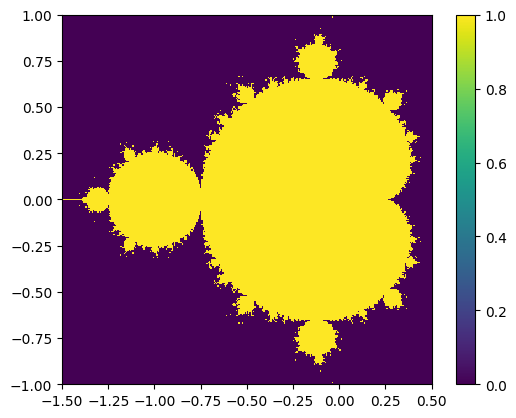

In [16]:
from matplotlib import pyplot as plt

%matplotlib inline
plt.imshow(result_binary, interpolation="none", extent=[xmin, xmax, ymin, ymax])
plt.colorbar()

Wow, that was TEN TIMES faster.

## Attempt 2: Return iterations

The function `mandel_binary` runs on an array and is faster than our previous implementations. At the moment, it returns a boolean value for each element of the input: `True` if the element is in the Mandelbrot set, `False` otherwise. 

It would be nice if the function returned, as before, the number of iterations that were performed. Let's modify the function to do exactly that:

In [30]:
def mandel_numpy(constants, max_iterations=50):
    # todo rename / reformat this to match our first mandel
    
    value = np.zeros(constants.shape)
    # An array which keeps track of the first step at which each position diverged
    diverged_at_count = np.ones(constants.shape)*max_iterations
    counter = 0
    while counter < max_iterations:
        value = value**2 + constants
        diverging = abs(value) > 2
        
        # Any positions which are:
        # - diverging
        # - haven't diverged before
        # are diverging for the first time
        first_diverged_this_time = np.logical_and(
            diverging,
            diverged_at_count == max_iterations
        )
        
        # Update diverged_at_count for all positions which first diverged at this step
        diverged_at_count[first_diverged_this_time] = counter
        # Reset any divergent values to exactly 2
        
        # todo would this be faster to set this to 0?
        value[diverging] = 2
        counter = counter + 1

    return diverged_at_count



In [ ]:
# def mandel_numpy_better(constants, max_iterations=50):
#     # todo: rename / reformat this to match our first mandel
#     # todo: make this give the right answer!
    
#     value = np.zeros(constants.shape)
#     # An array which keeps track of the first step at which each position diverged
#     diverged_at_count = np.ones(constants.shape)*50
#     counter = 0
#     while counter < max_iterations:
#         value = value**2 + constants
#         # Get elements that are diverging
#         diverging = abs(value) > 2
    
#         # Update diverged_at_count for all positions which at this step
#         diverged_at_count[diverging] = counter
        
#         # Stop the elements from diverging again
#         value[diverging] = 0
        
#         counter = counter + 1

#     return diverged_at_count


In [ ]:
%%timeit
mandel_numpy(cs)

In [31]:
result_numpy = mandel_numpy(cs)

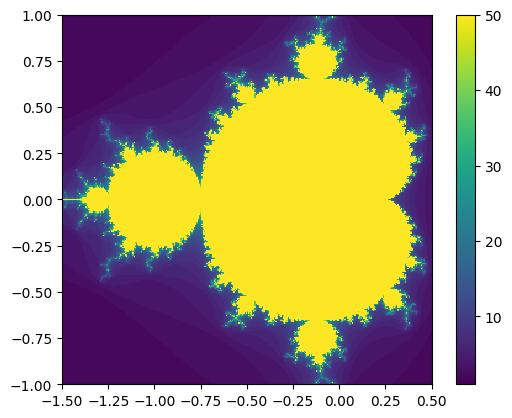

In [32]:
plt.imshow(result_numpy, interpolation="none", extent=[xmin, xmax, ymin, ymax])
plt.colorbar()

In [ ]:
%%timeit

data7 = mandel4(values)

Note that here, all the looping over mandelbrot steps was in Python, but everything below the loop-over-positions happened in C. The code was amazingly quick compared to pure Python.

## Attempt 3: Reduce number of operations

Note that we might worry that we carry on calculating the mandelbrot values for points that have already diverged.

In [39]:
def mandel_reduce_operations(constants, max_iterations=50):
    
    # todo add comments here
    value = np.zeros(constants.shape) + constants
    calculating = np.ones(constants.shape, dtype="bool") 
    diverged_at_count = np.ones(constants.shape)*max_iterations
    
    counter = 0
    while counter < max_iterations:
        value[calculating] = value[calculating] ** 2 + constants[calculating]
        diverging_now = np.zeros(constants.shape, dtype="bool")
        
        # undo this bit, put it back to *
        diverging_now[calculating] = (
            value[calculating] * np.conj(value[calculating]) > 4
        )
        
        calculating = np.logical_and(calculating, np.logical_not(diverging_now))
        diverged_at_count[diverging_now] = counter
        counter = counter + 1

    return diverged_at_count

In [40]:
result_reduce_operations = mandel_reduce_operations(cs)

In [36]:
%%timeit

mandel_reduce_operations(cs)

66.9 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


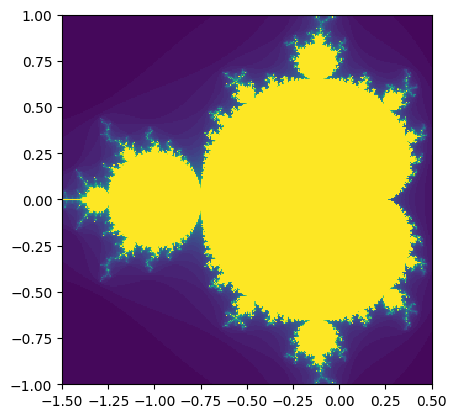

In [41]:
plt.imshow(result_reduce_operations, interpolation="none", extent=[xmin, xmax, ymin, ymax])

This was **not faster** even though it was **doing less work**

This often happens: on modern computers, **branches** (if statements, function calls) and **memory access** is usually the rate-determining step, not maths.

Complicating your logic to avoid calculations sometimes therefore slows you down. The only way to know is to **measure**

You need to *experiment* to see which optimisations will work. Performance programming needs to be empirical.